## corv: A Tutorial

[GitHub Page](https://github.com/vedantchandra/corv)

---

1. [Fitting A DA White Dwarf With Voigt Profiles](#da-no-template)
2. [Fitting A DA White Dwarf With Koester Templates](#da-template)
3. [Fitting A DB White Dwarf Without Koester Templates](#db-no-template)



The following is a series of examples of using $\texttt{corv}$ to calculate radial velocities of white dwarfs. It does this by isolating a portion of the spectrum around each absorption line. Then, $\texttt{corv}$ generates a model. When fitting without templates, that model consists of the control parameters of each Voigt profile plus a parameter for radial velocity, and when fitting with a template models consist of absorption lines calculated from model spectra by Koester et al. Then, $\texttt{corv}$ fits each parameter, determining a radial velocity.

We use astroquery to get an example spectrum. This is a good DA white dwarf.
This object was studied as a part of SDSS DR14
https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/MNRAS/486/2169/table3

RA = 38.765249544&deg; DEC = -0.48654748&deg;

This has $T_{\text{eff}} = 15020 \pm 87$ K ; $log[g] = 8.116 \pm 0.019$ ; $RV = 57 \pm 7$ km/s

In [1]:
import corv
from astroquery.sdss import SDSS
import matplotlib.pyplot as plt

/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
plate = 4239
mjd = 55458
fiberid = 274

spec = SDSS.get_spectra_async(plate=plate, fiberID=fiberid, mjd=mjd)[0].get_fits()

/home/arseneau/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


In [3]:
i = 1

wl = 10**spec[i].data['loglam']
fl = spec[i].data['flux']
ivar = spec[i].data['ivar']

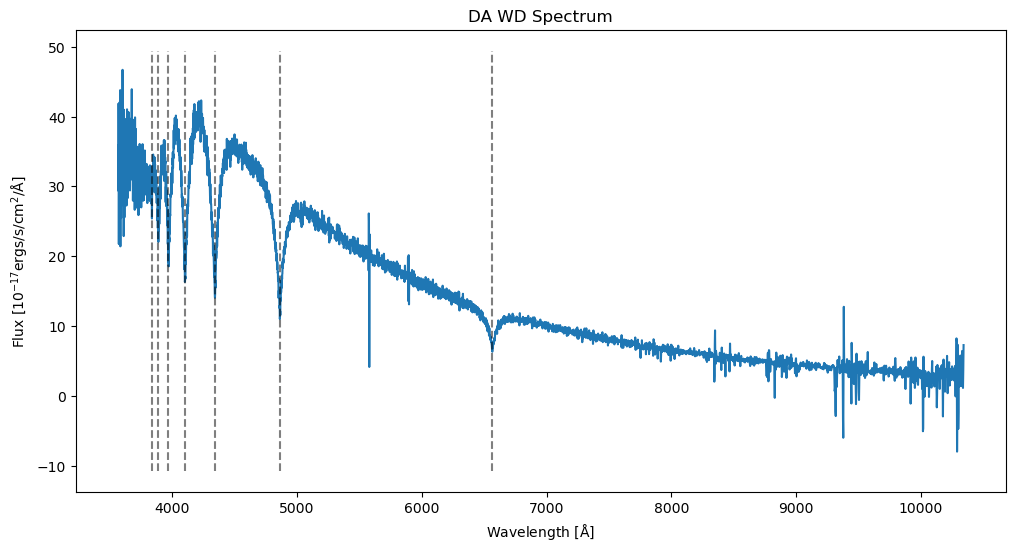

In [4]:
balmer_lines = [6562.79, 4861.35, 4340.47, 4101.73, 3970.07, 3889.06, 3835.40]

plt.figure(figsize=(12,6))
plt.plot(wl, fl)
min_, max_ = plt.ylim()
plt.vlines(balmer_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)
plt.ylabel(r'Flux [$10^{-17} \mathrm{ergs/s/cm^2/\AA}$]')
plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
plt.title('DA WD Spectrum');

We can view the Balmer $\alpha$ absorption line:

In [5]:
centres={'a': 6564.61, 'b': 4862.68, 'g': 4341.68, 'd': 4102.89, 'e': 3971.2, 'z': 3890.12, 'n': 3835.5,}
windows={'a': 250, 'b': 250, 'g': 80, 'd': 70, 'e': 30, 'z': 25, 'n': 15}
edges={'a': 40, 'b': 40, 'g': 20, 'd': 20, 'e': 5, 'z': 5, 'n': 5}
names=['n', 'z', 'e', 'd', 'g', 'b', 'a']

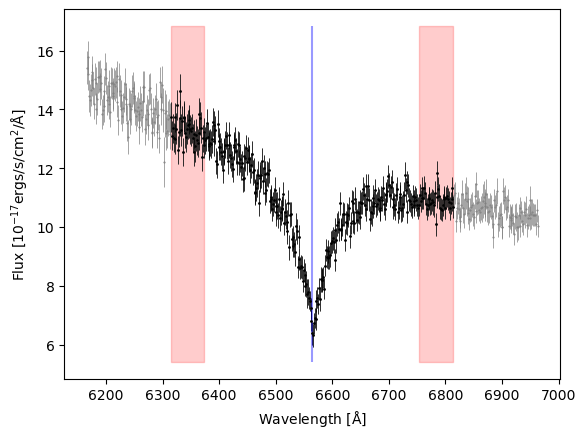

In [6]:
from bisect import bisect_left
import numpy as np

c1 = bisect_left(wl, centres['a'] - windows['a'] - 150)
c2 = bisect_left(wl, centres['a'] + windows['a'] + 150)
wl2, fl2, ivar2 = wl[c1:c2], fl[c1:c2], ivar[c1:c2]

plt.errorbar(wl2,fl2,yerr=ivar2**-0.5,linestyle=" ",marker='.',ms=1,lw=0.5,color='grey')

c1 = bisect_left(wl2, centres['a'] - windows['a'])
c2 = bisect_left(wl2, centres['a'] + windows['a'])
wl3, fl3, ivar3 = wl2[c1:c2], fl2[c1:c2], ivar2[c1:c2]

plt.errorbar(wl3,fl3,yerr=ivar3**-0.5,linestyle=" ",marker='.',ms=2,lw=0.5,color='k')

_min,_max = plt.ylim()
mask = np.zeros(len(wl3))
mask[:edges['a']] = 1
mask = mask.astype(bool)
plt.fill_between(wl3[mask],_min,_max,color='r',alpha=0.2)
mask = np.zeros(len(wl3))
mask[-edges['a']:] = 1
mask = mask.astype(bool)
plt.fill_between(wl3[mask],_min,_max,color='r',alpha=0.2)

plt.vlines(centres['a'],_min,_max,'blue',alpha=0.4)
plt.ylabel(r'Flux [$10^{-17} \mathrm{ergs/s/cm^2/\AA}$]');
plt.xlabel(r'Wavelength [$\mathrm{\AA}$]');

<a id="da-no-template"></a>

**01. Fitting With Voight Profiles**

---

Now we have the information we need to calculate the RV of this object. We do this by first creating a model and then fitting the model. This can be done in two lines:

`
corvmodel = corv.models.make_balmer_model(nvoigt = 2, names = ['a','b','g','d'])
`

This is the line that creates the model. `nvoigt = 2` tells $\texttt{corv}$ to fit each absorption line using 2 voigt profiles, and `names = ['a', 'b', 'g', 'd']` tells $\texttt{corv}$ to fit radial velocity using the Balmer $\alpha$, $\beta$, $\gamma$, and $\delta$ lines. It's not strictly necessary, but we also supply `corv` with the centers, windows, and edges we defined earlier. This just tells it how far to look around each absorption line.

`
param_res, rv_res, rv_init = corv.fit.fit_corv(wl, fl, ivar, corvmodel)
`

Next, we fit the model we've created. $\texttt{corv}$ takes wavelength, flux, and ivar as arguments as well as the model. It returns two $\texttt{lmfit}$ objects: `param_res` and `rv_res`, and a float: `rv_init`. $\texttt{corv}$ works in two steps of fitting. First, all parameters are fitted at the same time. These results are returned in `param_res`. Second, every variable except radial velocity is frozen at the values given in `param_res`, and a second round of fitting is performed where only radial velocity is allowed to vary. The final fitted radial velocity is the one given in `rv_res`. `rv_init` is the first guess radial velocity in km/s.

In short: if you want to use $\texttt{corv}$ radial velocities, use the radial velocity from `rv_res`.

<Parameter 'RV', value=53.52380514066954 +/- 5.74, bounds=[-2500:2500]>


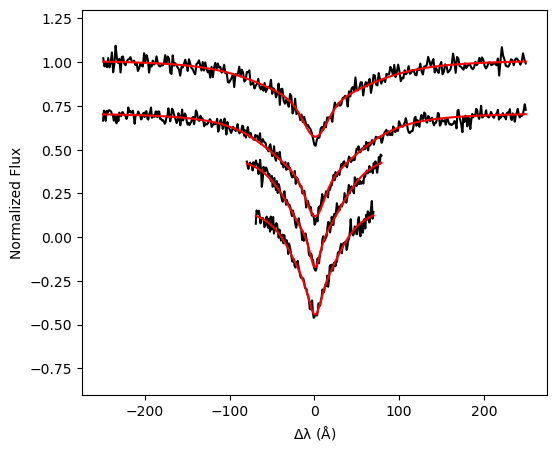

In [7]:
corvmodel = corv.models.make_balmer_model(nvoigt=2,names = ['a','b','g','d'],centres=centres,windows=windows,\
                                          edges=edges)

param_res, rv_res, rv_init = corv.fit.fit_corv(wl, fl, ivar, corvmodel)

corv.utils.lineplot(wl, fl, ivar, corvmodel, param_res.params, printparams = False, gap = 0.3, figsize = (6, 5))

print(rv_res.params['RV'])

<Parameter 'RV', value=53.52380514066954 +/- 5.74, bounds=[-2500:2500]>


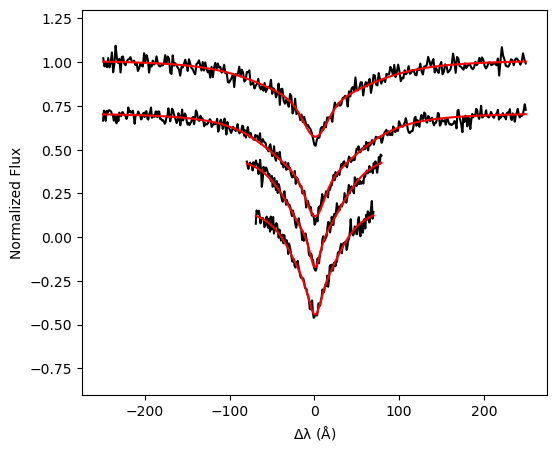

In [8]:
corv.utils.lineplot(wl, fl, ivar, corvmodel, param_res.params, printparams = False, gap = 0.3, figsize = (6, 5))

print(rv_res.params['RV'])

<a id="da-template"></a>

**02. Fitting With Koester Templates**

---

Now we can run the saem fit using Koester templates. This follows the same procedure as the Voigt fitting, but we use the function `corv.models.make_koester_model` instead.

In [9]:
corvmodel = corv.models.make_koester_model(names = ['a','b','g','d'],centres=centres,windows=windows,edges=edges)

param_res, rv_res, rv_init = corv.fit.fit_corv(wl, fl, ivar, corvmodel,iter_teff=True)

In [10]:
print(rv_res.params['RV'])

<Parameter 'RV', value=52.857695944906936, bounds=[-2500:2500]>


One of $\texttt{corv}$'s utility functions allows us to see how good of a fit we've made. This is the `lineplot` function:

`
corv.utils.lineplot(wl, fl, ivar, corvmodel, rv_res.params, printparams = False, gap = 0.3, figsize = (6, 5))
`

The first three inputs allow plotting of the raw data. `corvmodel` and `rv_res.params` tell $\texttt{corv}$ what model and what parameters for that model to use.

<a id="db-no-template"></a>

**03. Fitting A DB White Dwarf Without Templates**

---

We select the target J222711.11+073510.7 from the paper [Spectral Feature Extraction for DB White Dwarfs Through Machine Learning Applied to New Discoveries in the SDSS DR12 and DR14](https://doi.org/10.1088/1538-3873/aac7a8). This is a DB White Dwarf and they obtained a radial velocity of $50 \pm 12$kms$^{-1}$ for this object. Here, we analyse the same object with `corv`.

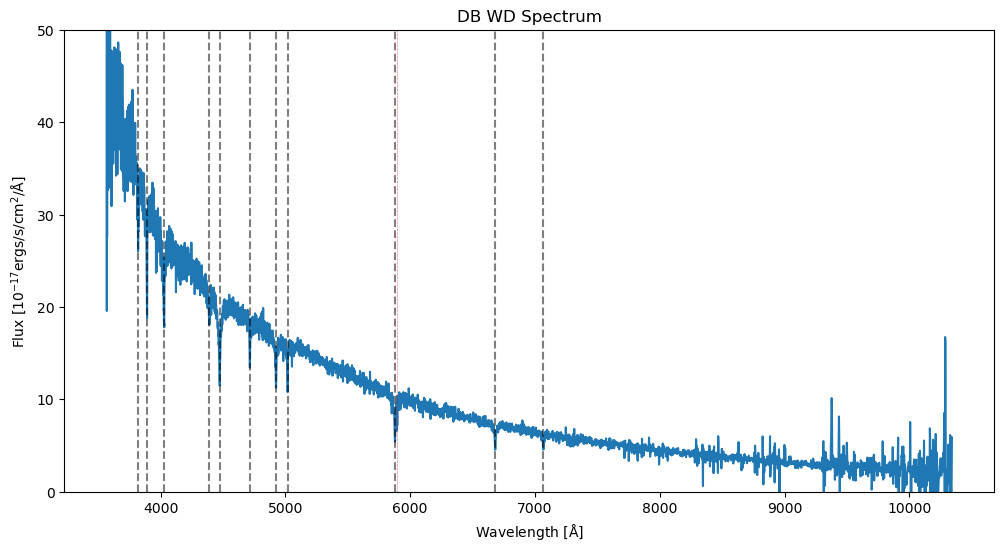

In [11]:
C2_line = [5889]
C2_line = corv.utils.air2vac(C2_line)

He_lines = [3819.607,3888.6489,4026.191,4387.929,4471.479,4713.146,4921.931,5015.678,5875.6148,6678.1517,7065.1771]
He_lines = corv.utils.air2vac(He_lines)

DB = SDSS.get_spectra_async(plate=5057, fiberID=276, mjd=56209)[0].get_fits()

wl_db = 10**DB[1].data['LOGLAM']
fl_db = DB[1].data['FLUX']
ivar_db = DB[1].data['IVAR']

plt.figure(figsize=(12,6))

plt.plot(wl_db, fl_db)
min_, max_ = 0,50
plt.vlines(He_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)
plt.vlines(C2_line, min_, max_, colors = 'red', linestyle = 'dashed', alpha = 0.5,lw=0.5)
plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
plt.xlabel(r'Wavelength [A]')
plt.title('DB WD Spectrum')
plt.ylabel(r'Flux [$10^{-17} \mathrm{ergs/s/cm^2/\AA}$]')
plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
plt.ylim(min_,max_);

Now we choose the lines we want to use to determine RV. We first list all the lines, and desired window size and the edge sizes. To choose window size we can plot the spectra and make sure there's no other feature within the window (w.r.t to the centre). To choose the edge size we can make sure the sborption is reasonably within this value and that the continuim can be obtained from rest of it.

We drop lines based on nearby metal lines/noise/shallow absorption feature

We choose to make our own model using voigt profile with `nvoigt=2`. Ideally, we should use the DB spectral template but we get a very good result even without them.

In [12]:
centre = {'a':He_lines[0],'b':He_lines[1],'c':He_lines[2],'d':He_lines[3],'e':He_lines[4],'f':He_lines[5],\
          'g':He_lines[6],'h':He_lines[7],'i':He_lines[8],'j':He_lines[9],'k':He_lines[10]}
window = {'a':40,'b':40,'c':50,'d':50,'e':50,'f':50,'g':60,'h':60,'i':60,'j':80,'k':80}
edge = {'a':25,'b':25,'c':35,'d':35,'e':35,'f':35,'g':35,'h':35,'i':35,'j':40,'k':40}
name = ['a','b','c','d','e','f','g','h','i','j','k']

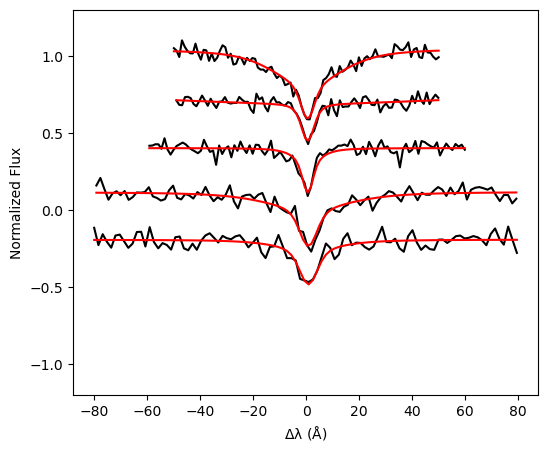

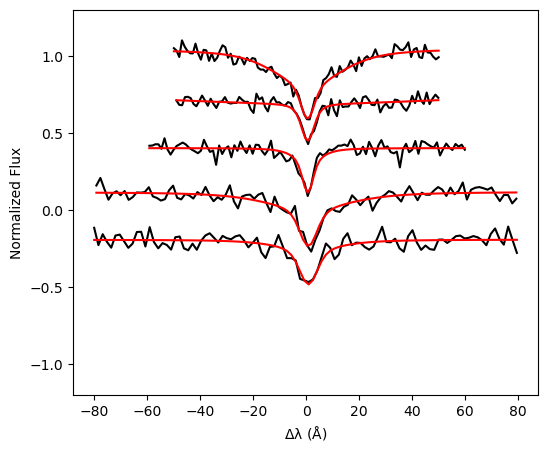

In [13]:
db_model = corv.models.make_balmer_model(nvoigt=2,centres=centre,windows=window,edges=edge,\
                                       names=['e','f','h','j','k'])

param_res_db, rv_res_db, rv_init = corv.fit.fit_corv(wl_db, fl_db, ivar_db,db_model)

corv.utils.lineplot(wl_db, fl_db, ivar_db, db_model, rv_res_db.params, printparams = False, gap = 0.3, figsize = (6, 5))

In [14]:
print(rv_res_db.params['RV'])

<Parameter 'RV', value=36.828076887500174 +/- 4.48, bounds=[-2500:2500]>
